Advanced Lane Finding

Udacity - Self-Driving Car NanoDegree

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. Check out the writeup template for this project and use it as a starting point for creating your own writeup.
Creating a great writeup:

A great writeup should include the rubric points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references. You should include images in your writeup to demonstrate how your code works with examples.

All that said, please be concise! We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :).

You're not required to use markdown for your writeup. If you use another method please just submit a pdf of your writeup.
The Project

The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [14]:
import glob

def getObjAndImgPointsFromChessBoardImages(col = 9, row = 6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((col*row,3), np.float32)
    objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (col,row), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

In [15]:
objpoints, imgpoints = getObjAndImgPointsFromChessBoardImages()

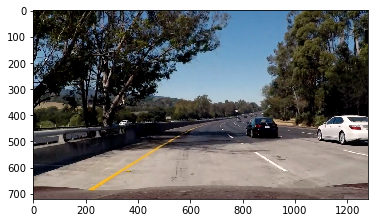

In [130]:
img = mpimg.imread('test_images/test5.jpg')
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)


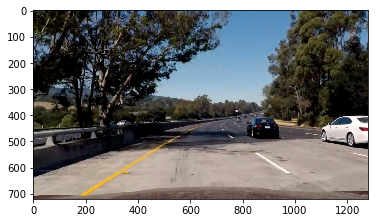

In [131]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)


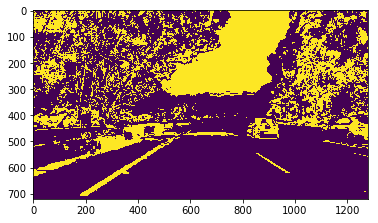

In [132]:
def hls_select(img, thresh=(80, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(dst)
plt.imshow(hls_binary)

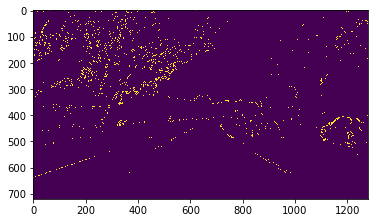

In [133]:
def CombineAllThresholds(img, thresh_min=30, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value    
    abs_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    abs_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # Rescale back to 8 bit integer
    scaled_sobel_x = np.uint8(255*abs_x/np.max(abs_x))
    scaled_sobel_y = np.uint8(255*abs_y/np.max(abs_y))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel_x)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel_x >= thresh_min) & (scaled_sobel_x <= thresh_max) &
                  (scaled_sobel_y >= thresh_min) & (scaled_sobel_y <= thresh_max)
                 ] = 1    

    return binary_output

threshold = CombineAllThresholds(dst)
plt.imshow(threshold)

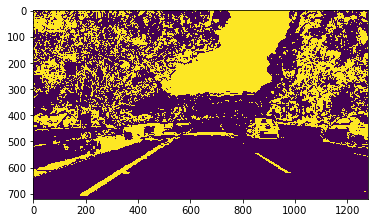

In [134]:
def CombineAllThresholdsAndHLS(img):
    hls_binary = hls_select(img)
    threshold = CombineAllThresholds(dst)

    binary_output = np.zeros_like(threshold)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(hls_binary == 1) | (threshold == 1)] = 1    

    return binary_output

final = CombineAllThresholdsAndHLS(dst)
plt.imshow(final)

In [150]:
def getPerspectiveSrcDst(img, rho = 10, theta = 3*np.pi/180, threshold = 12, 
                min_line_len = 40, max_line_gap = 5):

    # add region of interest
    shape = img.shape
    vertices = np.array([[(50, shape[0]), (shape[1]/2, shape[0]*0.52), (shape[1]-50, shape[0])]], dtype=np.int32)
    ignore_mask_color = 255
    mask = np.zeros_like(img)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)    
    img = cv2.bitwise_and(img, mask)

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    posSlop_len = 0
    negSlop_len = 0
    pos_m = None
    pos_b = None
    neg_m = None
    neg_b = None
    PosLine = None
    NegLine = None
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (float)(y2-y1)/(float)(x2-x1)
            b = y1 - m*x1
            length = (y2-y1)*(y2-y1) + (x2-x1)*(x2-x1)
            if m > 0 and length > posSlop_len:
                posSlop_len = length
                PosLine = line
                pos_m = m
                pos_b = b
            if m < 0 and length > negSlop_len:
                negSlop_len = length
                NegLine = line
                neg_m = m
                neg_b = b
    # wrap the two point on Positive line so that the ordering of the lines are consistant
    t1 = PosLine[0][0]
    t2 = PosLine[0][1]
    PosLine[0][0] = PosLine[0][2]
    PosLine[0][1] = PosLine[0][3]
    PosLine[0][2] = t1
    PosLine[0][3] = t2
    print ("Pos: ", PosLine, "pos_m: ", pos_m, pos_b)
    print ("Neg: ", NegLine, "neg_m: ", neg_m, neg_b)
    if PosLine[0][1] > NegLine[0][1]:
        NegLine[0][1] = PosLine[0][1]
        NegLine[0][0] = int((NegLine[0][1] - neg_b)/neg_m)
    else:
        PosLine[0][1] = NegLine[0][1]
        PosLine[0][0] = int((PosLine[0][1] - pos_b)/pos_m)

    if PosLine[0][3] < NegLine[0][3]:
        NegLine[0][3] = PosLine[0][3]
        NegLine[0][2] = int((NegLine[0][3] - neg_b)/neg_m)
    else:
        PosLine[0][3] = NegLine[0][3]
        PosLine[0][2] = int((PosLine[0][3] - pos_b)/pos_m)
    print ("Pos: ", PosLine, "pos_m: ", pos_m, pos_b)
    print ("Neg: ", NegLine, "neg_m: ", neg_m, neg_b)
    src_point = np.float32([[PosLine[0][0], PosLine[0][1]],
                            [PosLine[0][2], PosLine[0][3]],
                            [NegLine[0][0], NegLine[0][1]],
                            [NegLine[0][2], NegLine[0][3]],
                           ])
    
    print(src_point)
    dst_point = np.float32([[PosLine[0][0], PosLine[0][1]],
                            [PosLine[0][0]-100, PosLine[0][3]],
                            [NegLine[0][0], NegLine[0][1]],
                            [NegLine[0][0]+100, NegLine[0][3]],
                           ])
    print(dst_point)
    return src_point, dst_point

Pos:  [[982 620 847 543]] pos_m:  0.5703703703703704 59.8962962963
Neg:  [[205 707 539 490]] neg_m:  -0.6497005988023952 840.188622754
Pos:  [[1134  707  754  490]] pos_m:  0.5703703703703704 59.8962962963
Neg:  [[205 707 539 490]] neg_m:  -0.6497005988023952 840.188622754
[[ 1134.   707.]
 [  754.   490.]
 [  205.   707.]
 [  539.   490.]]
[[ 1134.   707.]
 [ 1034.   490.]
 [  205.   707.]
 [  305.   490.]]


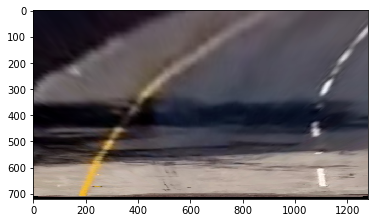

In [153]:
src_p, dst_p = getPerspectiveSrcDst(final)
M = cv2.getPerspectiveTransform(src_p, dst_p)
img_size = (dst.shape[1], dst.shape[0])
warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

In [52]:
print (len(final.shape))

2


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


NameError: name 'binary_warped' is not defined

In [2]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


NameError: name 'binary_warped' is not defined

In [3]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


NameError: name 'binary_warped' is not defined

In [4]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


NameError: name 'binary_warped' is not defined

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [6]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


1751.01856778 1571.03858617


In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


575.122249676 m 515.923506864 m


In [8]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)


NameError: name 'warped' is not defined